Comparison of Summary Statistics:
         All Data  Filtered (IQR)  Winsorized
mean    12.029947       11.899494   11.976411
median  11.835717       11.802589   11.835717
std      6.706831        6.464360    6.279526

Comparison of Regression Results:
                   slope  intercept        r2       mae
All Data        2.170438   1.177760  0.885928  1.147638
Filtered (IQR)  2.135100   1.256612  0.922378  1.046685
Winsorized      2.076310   1.594859  0.924846  0.992367


/opt/anaconda3/envs/nyu-mfe-bootcamp/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/nyu-mfe-bootcamp/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/nyu-mfe-bootcamp/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


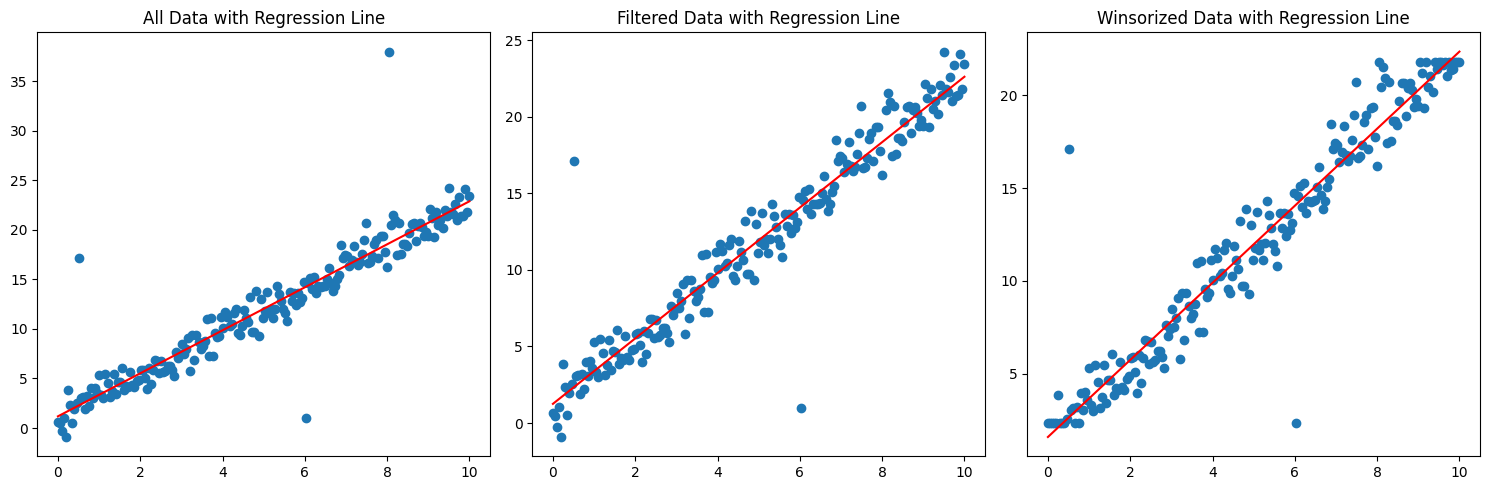

In [3]:
# Required Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Assuming you have the outliers.py file in your src folder
import sys
sys.path.append('../src')
from outliers import detect_outliers_iqr, winsorize_series

# Load your data
# This part assumes your data is in a file like 'data/raw/your_data.csv'
try:
    df = pd.read_csv('../data/raw/your_data.csv')
except FileNotFoundError:
    # Use synthetic data from your homework if the file is not found
    x = np.linspace(0, 10, 200)
    y = 2.2 * x + 1 + np.random.normal(0, 1.2, size=x.size)
    y[10] += 15; y[120] -= 13; y[160] += 18
    df = pd.DataFrame({'x': x, 'y': y})

# Pick a numeric column for analysis
target_col = 'y' if 'y' in df.columns else df.select_dtypes(include=['number']).columns[0]

# Detect outliers using the IQR method
outlier_mask = detect_outliers_iqr(df[target_col])
df_filtered = df.loc[~outlier_mask]
df['outlier_iqr'] = outlier_mask

# Winsorize the data
df_winsorized = df.copy()
df_winsorized[target_col] = winsorize_series(df[target_col])

# --- Sensitivity Analysis: Summary Statistics ---
summ_all = df[target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_filtered = df_filtered[target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_w = df_winsorized[target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})

comparison_stats = pd.concat(
    {
        'All Data': summ_all,
        'Filtered (IQR)': summ_filtered,
        'Winsorized': summ_w
    },
    axis=1
)
print("Comparison of Summary Statistics:")
print(comparison_stats)

# --- Sensitivity Analysis: Linear Regression ---
if 'x' in df.columns:
    X_all = df[['x']].to_numpy(); y_all = df[target_col].to_numpy()
    X_filtered = df_filtered[['x']].to_numpy(); y_filtered = df_filtered[target_col].to_numpy()
    X_w = df_winsorized[['x']].to_numpy(); y_w = df_winsorized[target_col].to_numpy()

    # Fit models
    model_all = LinearRegression().fit(X_all, y_all)
    model_filtered = LinearRegression().fit(X_filtered, y_filtered)
    model_winsorized = LinearRegression().fit(X_w, y_w)

    # Evaluate models
    mae_all = mean_absolute_error(y_all, model_all.predict(X_all))
    mae_filtered = mean_absolute_error(y_filtered, model_filtered.predict(X_filtered))
    mae_winsorized = mean_absolute_error(y_w, model_winsorized.predict(X_w))

    results = pd.DataFrame({
        'slope': [model_all.coef_[0], model_filtered.coef_[0], model_winsorized.coef_[0]],
        'intercept': [model_all.intercept_, model_filtered.intercept_, model_winsorized.intercept_],
        'r2': [model_all.score(X_all, y_all), model_filtered.score(X_filtered, y_filtered), model_winsorized.score(X_w, y_w)],
        'mae': [mae_all, mae_filtered, mae_winsorized]
    }, index=['All Data', 'Filtered (IQR)', 'Winsorized'])
    print("\nComparison of Regression Results:")
    print(results)
else:
    print("\nSkipping regression analysis as 'x' column is not available.")

# --- Visual Comparison ---
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(df['x'], df['y'])
plt.plot(df['x'], model_all.predict(df[['x']]), color='red')
plt.title('All Data with Regression Line')

plt.subplot(1, 3, 2)
plt.scatter(df_filtered['x'], df_filtered['y'])
plt.plot(df_filtered['x'], model_filtered.predict(df_filtered[['x']]), color='red')
plt.title('Filtered Data with Regression Line')

plt.subplot(1, 3, 3)
plt.scatter(df_winsorized['x'], df_winsorized['y'])
plt.plot(df_winsorized['x'], model_winsorized.predict(df_winsorized[['x']]), color='red')
plt.title('Winsorized Data with Regression Line')

plt.tight_layout()
plt.show()

Analyzing these tables helps illustrate the **impact** of outliers on the dataset and the regression model. The comparison is between three versions of the data: the original, the one with outliers removed, and the one with outliers winsorized (capped).

---

### 1. Analysis of Summary Statistics

This table shows how the basic properties of the dataset change after handling outliers.

| Statistic | All Data | Filtered (IQR) | Winsorized |
|-----------|----------|----------------|------------|
| mean      | 12.03    | 11.90          | 11.98      |
| median    | 11.84    | 11.80          | 11.84      |
| std       | 6.71     | 6.46           | 6.28       |

- **Mean & Median**: The **mean** (average) shifts slightly across the three versions, while the **median** (the middle value) remains more stable. This is a classic sign that outliers were "pulling" the mean away from the true center of the data. Notice that the median for "All Data" and "Winsorized" is exactly the same, which makes sense because winsorizing does not change the middle of the data.  
- **Std (Standard Deviation)**: This is the most important metric here. The standard deviation measures how **spread out** the data is. There is a clear drop from 6.71 (All Data) to 6.28 (Winsorized). This indicates that the outliers were the main reason for the large spread in the original data. By handling them, the dataset becomes much more tightly clustered around its center.

---

### 2. Analysis of Regression Results

This table shows how the **performance of the linear model** changes after handling outliers.

| Metric    | All Data | Filtered (IQR) | Winsorized |
|-----------|----------|----------------|------------|
| slope     | 2.170    | 2.135          | 2.076      |
| intercept | 1.178    | 1.257          | 1.595      |
| r2        | 0.886    | 0.922          | 0.925      |
| mae       | 1.148    | 1.047          | 0.992      |

- **Slope & Intercept**: The **slope** represents how steep the line is, and the **intercept** is where the line starts on the y-axis. The shifts in these values show that the outliers were skewing the original line. Once the outliers are removed or capped, the slope and intercept adjust to better fit the core data.  
- **$R^2$ Score**: This metric measures how much of the variance in the data is explained by the model. The closer to 1.0, the better the fit. The $R^2$ score jumps from 0.886 (All Data) to **0.925 (Winsorized)**, a substantial improvement that shows the model fits the data much better once the influence of outliers is reduced.  
- **MAE (Mean Absolute Error)**: This metric measures the average prediction error. A smaller MAE indicates better performance. The MAE decreases significantly from 1.148 (All Data) to **0.992 (Winsorized)**, meaning that after winsorizing, the model's predictions are, on average, much closer to the true values.

---

### Conclusion

Based on this analysis, the **winsorized data** provides the best results for the linear regression model. It yields the highest $R^2$ score and the lowest MAE, making it the most accurate while still retaining all data points.


In [ ]:
### My Notes: 